In [1]:
# load up the data in Phi4 into a dataframe

import pandas as pd
import numpy as np
import os
import itertools
import jax.numpy as jnp
from sampler_evaluation.models.phi4 import phi4


samplers = [[f"adjusted_microcanonical_{integrator}", f"nuts_{integrator}", f"unadjusted_microcanonical_{integrator}"] for integrator in ['velocity_verlet', 'mclachlan', 'omelyan']]

samplers = list(itertools.chain(*samplers))


reduced_lam = np.linspace(-2.5, 7.5, 8) #lambda range around the critical point (m^2 = -4 is fixed)

def pad(x):
    if len(x) == 4:
        return x + '0'
    else:
        return x


def unreduce_lam(reduced_lam, side):
    """see Fig 3 in https://arxiv.org/pdf/2207.00283.pdf"""
    return 4.25 * (reduced_lam * np.power(side, -1.0) + 1.0)


def reduce(lam, side):
    unreduced_lam = unreduce_lam(reduced_lam, side=side)
    # print(unreduced_lam)
    # print(lam)
    # print(side)
    unreduced_lam = [pad(str(x)[:5]) for x in unreduced_lam.tolist()]
    # print(unreduced_lam)
    # print(str(lam))
    i = unreduced_lam.index(pad(str(lam)))
    return reduced_lam[i]

models={
                phi4(L=L, lam=lam).name for L in [8,16] for lam in unreduce_lam(reduced_lam=reduced_lam,side=L) 
            }

import os
print(os.listdir())

df = pd.concat([pd.read_csv(os.path.join("results", f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

df = df[df['max'] == True]
df = df[df['statistic'] == 'x2']

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
 

['adjusted_microcanonical_langevin_Phi4_L4_lam1.csv', 'results', 'phi4.py', 'phi4.ipynb']


In [2]:
df

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,max,statistic,num_tuning_grads,L,step_size
0,0,adjusted_microcanonical_velocity_verlet,Phi4_L16_lam3.585,19115.531061,True,x2,150734.00,31.600367,3.706691
4,0,adjusted_microcanonical_velocity_verlet,Phi4_L8_lam4.439,12951.095093,True,x2,154303.50,16.000000,1.480793
8,0,adjusted_microcanonical_velocity_verlet,Phi4_L16_lam3.965,39391.672031,True,x2,163452.25,32.000000,3.234713
12,0,adjusted_microcanonical_velocity_verlet,Phi4_L16_lam5.483,23703.605521,True,x2,188703.50,32.000000,2.653465
16,0,adjusted_microcanonical_velocity_verlet,Phi4_L16_lam5.862,30182.582647,True,x2,185752.75,32.000000,2.685852
...,...,...,...,...,...,...,...,...,...
556,0,unadjusted_microcanonical_omelyan,Phi4_L8_lam6.716,9005.000000,True,x2,55550.00,17.688542,6.774416
560,0,unadjusted_microcanonical_omelyan,Phi4_L8_lam3.680,10635.000000,True,x2,55550.00,247.378623,7.855553
564,0,unadjusted_microcanonical_omelyan,Phi4_L16_lam4.344,52565.000000,True,x2,55550.00,343.951660,10.365640
568,0,unadjusted_microcanonical_omelyan,Phi4_L8_lam7.475,5370.000000,True,x2,55550.00,14.497380,6.599630


In [3]:
df['side'] = df['Model'].apply(lambda x: int(x.split("_")[1][1:]) )
df['dim'] = df['side']**2
df['Lam'] = df['Model'].apply(lambda x: float(x.split("_")[-1][3:]))
df['reduced_lam'] = df.apply(lambda x: reduce(x.Lam, x.side), axis=1)
# df['Lam'] = df['index']
# df["reduced_lam"] = np.linspace(-2.5, 7.5, 8)
df['ESS'] = 100 / df["num_grads_to_low_error"] 
                                            
# plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_theme(style="whitegrid")
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(8, 4))

# sns.lineplot(data=df, x='Lam', y='num_grads_to_low_error', hue='Sampler', markers=True, dashes=False)
# sns.lineplot(data=df, x='Lam', y='ESS', hue='Sampler', markers=True, dashes=False)

# sns.heatmap(df.pivot("dim", "Lam", "ESS"), cmap="viridis", annot=True, fmt=".1f", cbar_kws={'label': 'ESS'}, xticklabels=2, yticklabels=2)



new_df = df[df['Sampler']=='nuts'].pivot(index="dim", columns="reduced_lam", values="ESS")
new_df
sns.heatmap(new_df, annot=True, fmt=".4f", cbar_kws={'label': 'ESS'}, xticklabels=2, yticklabels=2, annot_kws={"size": 8})
# x axis: \bar{\lambda}
plt.xlabel("Reduced Lambda")
# title: Nuts Phi 4
plt.title("Nuts Phi 4")
# sns.heatmap(data=new_df, x='Lam', y='dim', hue='ESS', cmap="viridis", annot=True, fmt=".1f", cbar_kws={'label': 'ESS'}, xticklabels=2, yticklabels=2)

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 800x400 with 0 Axes>

In [32]:
# sns.set_theme(style="whitegrid")
# matplotlib.rcParams.update({'font.size': 22})
# plt.figure(figsize=(16, 16))

# new_df = df[df['Sampler']=='adjusted_microcanonical'].pivot(index="dim", columns="reduced_lam", values="ESS")
# new_df
# sns.heatmap(new_df, annot=True, fmt=".4f", cbar_kws={'label': 'ESS'}, xticklabels=2, yticklabels=2, annot_kws={"size": 12})

In [57]:
# sns.set_theme(style="whitegrid")
# matplotlib.rcParams.update({'font.size': 22})
# plt.figure(figsize=(16, 16))

# new_df = df[df['Sampler']=='unadjusted_microcanonical'].pivot(index="dim", columns="reduced_lam", values="ESS")
# new_df
# sns.heatmap(new_df, annot=True, fmt=".4f", cbar_kws={'label': 'ESS'}, xticklabels=2, yticklabels=2, annot_kws={"size": 12})
# df
df[df['reduced_lam']==7.5]

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,max,statistic,num_tuning_grads,L,step_size,dim,Lam,reduced_lam,ESS
0,0,unadjusted_microcanonical,Phi4_L32_lam5.246,17074.000000,True,x2,22220.000000,132.302047,14.916906,32,5.246,7.5,0.005857
40,0,unadjusted_microcanonical,Phi4_L16_lam6.242,7238.000000,True,x2,22220.000000,36.558147,7.816746,16,6.242,7.5,0.013816
52,0,unadjusted_microcanonical,Phi4_L8_lam8.234,3868.000000,True,x2,22220.000000,12.411582,4.101702,8,8.234,7.5,0.025853
96,0,nuts,Phi4_L32_lam5.246,108514.454400,True,x2,209562.750000,3.979363,0.123137,32,5.246,7.5,0.000922
136,0,nuts,Phi4_L16_lam6.242,30377.166325,True,x2,87930.296875,3.182919,0.186916,16,6.242,7.5,0.003292
148,0,nuts,Phi4_L8_lam8.234,13820.053125,True,x2,71485.265625,3.890610,0.259015,8,8.234,7.5,0.007236
192,0,adjusted_microcanonical,Phi4_L32_lam5.246,42220.879443,True,x2,355467.250000,64.000000,3.593271,32,5.246,7.5,0.002368
232,0,adjusted_microcanonical,Phi4_L16_lam6.242,20296.418298,True,x2,183089.867188,32.000000,2.759103,16,6.242,7.5,0.004927
244,0,adjusted_microcanonical,Phi4_L8_lam8.234,8781.824893,True,x2,134331.851562,15.493169,2.072202,8,8.234,7.5,0.011387


NameError: name 'df' is not defined

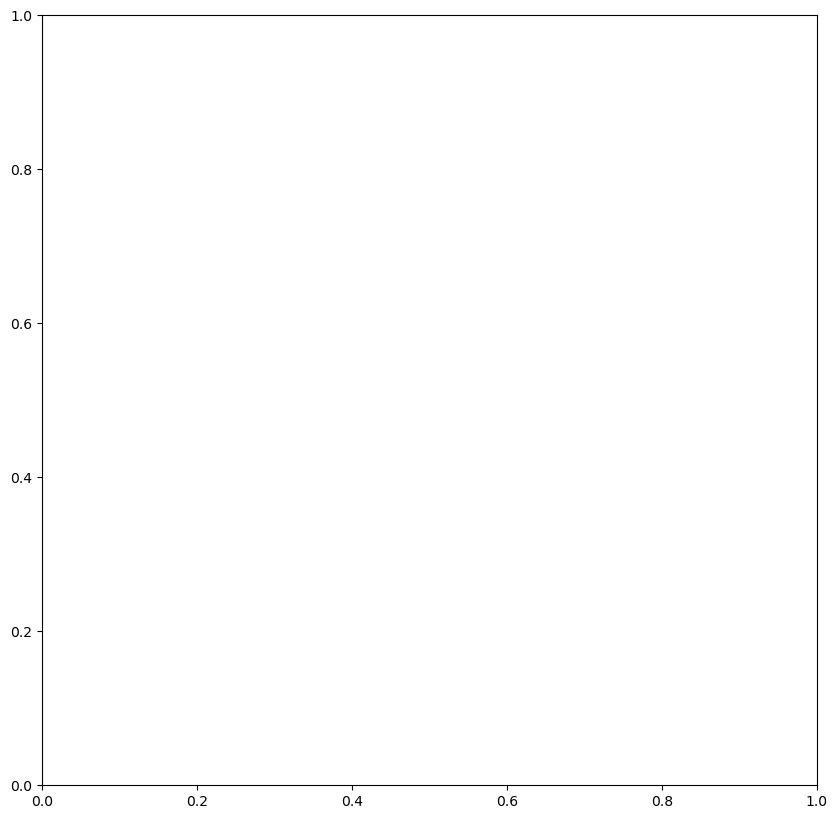

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.lineplot(data=df[df['reduced_lam']==7.5], x='dim', y='num_grads_to_low_error', hue='Sampler', markers=True, dashes=False,ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

## y = x^{1/4} lines
x = np.linspace(2, 20000, 100)
y = x**(1/4)
# y2 = x**(1/8)

for a in np.logspace(4,6,10):
    y = x**(1/4) * a
    # y2 = x**(1/8) * a
    ax.plot(x, y, linestyle='--', color='grey', alpha=0.2)
    # ax.plot(x, y2, linestyle='-.', color='red', alpha=0.2)


# 1/4 power line
# x = np.linspace(2, 20000, 100)
# y = x**(1/4)
# plt.plot(x, y, label="N^(1/4)")
